In [8]:
import sys
sys.path.append("../")

PATH = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/"
from modules.learning.models import *
from modules.learning.train import train_model
from modules.utils import hc
from modules.visualize import plot_loss, plot_normalized_time_error

# from modules.learning.evaluate import Evaluation, get_latent_space, plot_umap
from matplotlib import pyplot as plt
from modules.learning.dycep import DYCEP
import json
from types import SimpleNamespace


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# enet = EfficientNet()


track_path = PATH + "track_datasets/control_mm/train/images/"
label_path = PATH + "track_datasets/control_mm/train/labels/"

in_channels = [1]


In [12]:
model_number = 21

conf_path = f"../weights/config-2025_01_07_23_18.json"

# load dict in .json file
with open(conf_path, "r") as file:
    config = json.load(file)
if "temporal_encoder" not in config:
    print(f"temporal_encoder is Mamba")
    t_encoder_name = "Mamba"
else:
    t_encoder = config['temporal_encoder']
    print(f"temporal_encoder {t_encoder}")
print(f"num_epochs {config['num_epochs']}")
print(f"batch_size {config['batch_size']}")
print(f"test loss {config['test_loss'][-1]:.3f}")
if "partial_track_prob" in config:
    print(f"partial_track_prob {config['partial_track_prob']}")

temporal_encoder Mamba
num_epochs 1
batch_size 1
test loss 0.019
partial_track_prob 0.0


In [13]:
config["training_time"]

126.16818022727966

dict_keys(['number', 'path', 'name', 'model_type', 'img_channels', 'batch_size', 'num_epochs', 'learning_rate', 'train_loss', 'test_loss', 'train_R2', 'test_R2', 'temporal_encoder', 'partial_track_prob', 'training_time'])


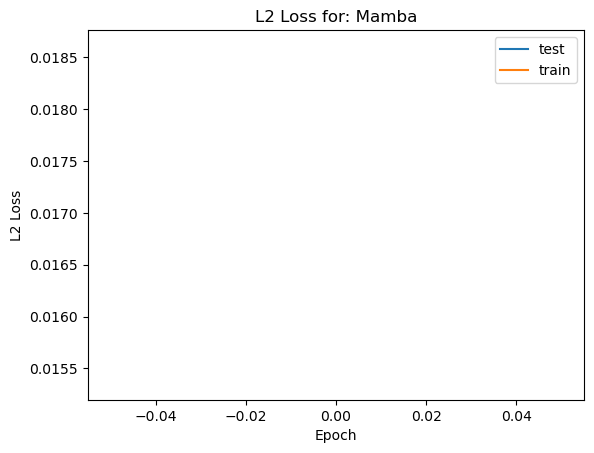

In [14]:
img_channel = config['img_channels']

print(config.keys())
plt.title(f"L2 Loss for: {t_encoder}")
plt.plot(config["test_loss"], label="test")
plt.plot(config["train_loss"], label="train")

plt.ylabel("L2 Loss")
plt.xlabel("Epoch")

plt.legend()

In [6]:
from types import SimpleNamespace

configg = SimpleNamespace(**config)


In [8]:
if configg.temporal_encoder == "mamba":
    from modules.learning.time_encoders.mamba import Mamba, MambaConfig

    temporal_encoder = Mamba(
        MambaConfig(
            configg.temporal_encoder_dim, configg.temporal_encoder_layers, d_state=16
        )
    )
elif configg.temporal_encoder == "transformer":
    temporal_encoder = nn.TransformerEncoder(
        nn.TransformerEncoderLayer(
            d_model=configg.temporal_encoder_dim,
            nhead=8,
            dim_feedforward=configg.temporal_encoder_dim * 2,
            batch_first=True,
        ),
        num_layers=configg.temporal_encoder_layers - 1,
    )
elif configg.temporal_encoder == "LSTM":
    temporal_encoder = nn.LSTM(
        input_size=256,
        hidden_size=256,
        num_layers=6,
        batch_first=True,
        bidirectional=False,
    )

In [15]:
model = DYCEP(
    cnn_in_channels=len(in_channels), temporal_encoder=temporal_encoder
)
model.to(DEVICE)

NameError: name 'temporal_encoder' is not defined

dict_keys(['number', 'path', 'name', 'model_type', 'img_channels', 'batch_size', 'num_epochs', 'learning_rate', 'train_loss', 'test_loss', 'train_R2', 'test_R2', 'temporal_encoder', 'partial_track_prob'])


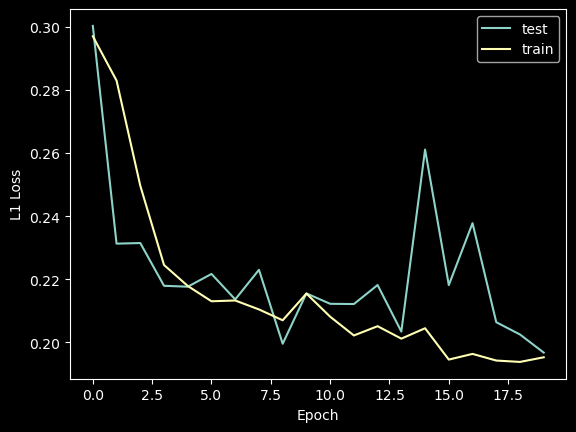

In [10]:
print(config.keys())

l1_train = np.sqrt(config["train_loss"])
l1_test = np.sqrt(config["test_loss"])

plt.plot(l1_test, label="test")
plt.plot(l1_train, label="train")

plt.ylabel("L1 Loss")
plt.xlabel("Epoch")

plt.legend()

In [11]:
from modules.learning.evaluate import Evaluation

model.load_state_dict(torch.load(f"weights/model-{model_number}.pt"))


2024-12-11 21:28:32.666089: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-11 21:28:33.243875: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<All keys matched successfully>

In [12]:
# eval_subpath = "datasets/Palbociclib/"
# eval_subpath = "datasets/Control/test/"
eval_subpath = "track_datasets/control_mm/test/"

eval = Evaluation()
eval.fit(
    PATH + eval_subpath, model, img_channels=img_channel, smoothing=True
)

100%|██████████| 358/358 [00:07<00:00, 46.47it/s]


----------------------------------------------------------------------
Model Performance:
\ell_1: 0.074 ± 0.030
\ell_2: 0.017 ± 0.020
W_d: 0.055 ± 0.020
Accuracy: 0.888 ± 0.073



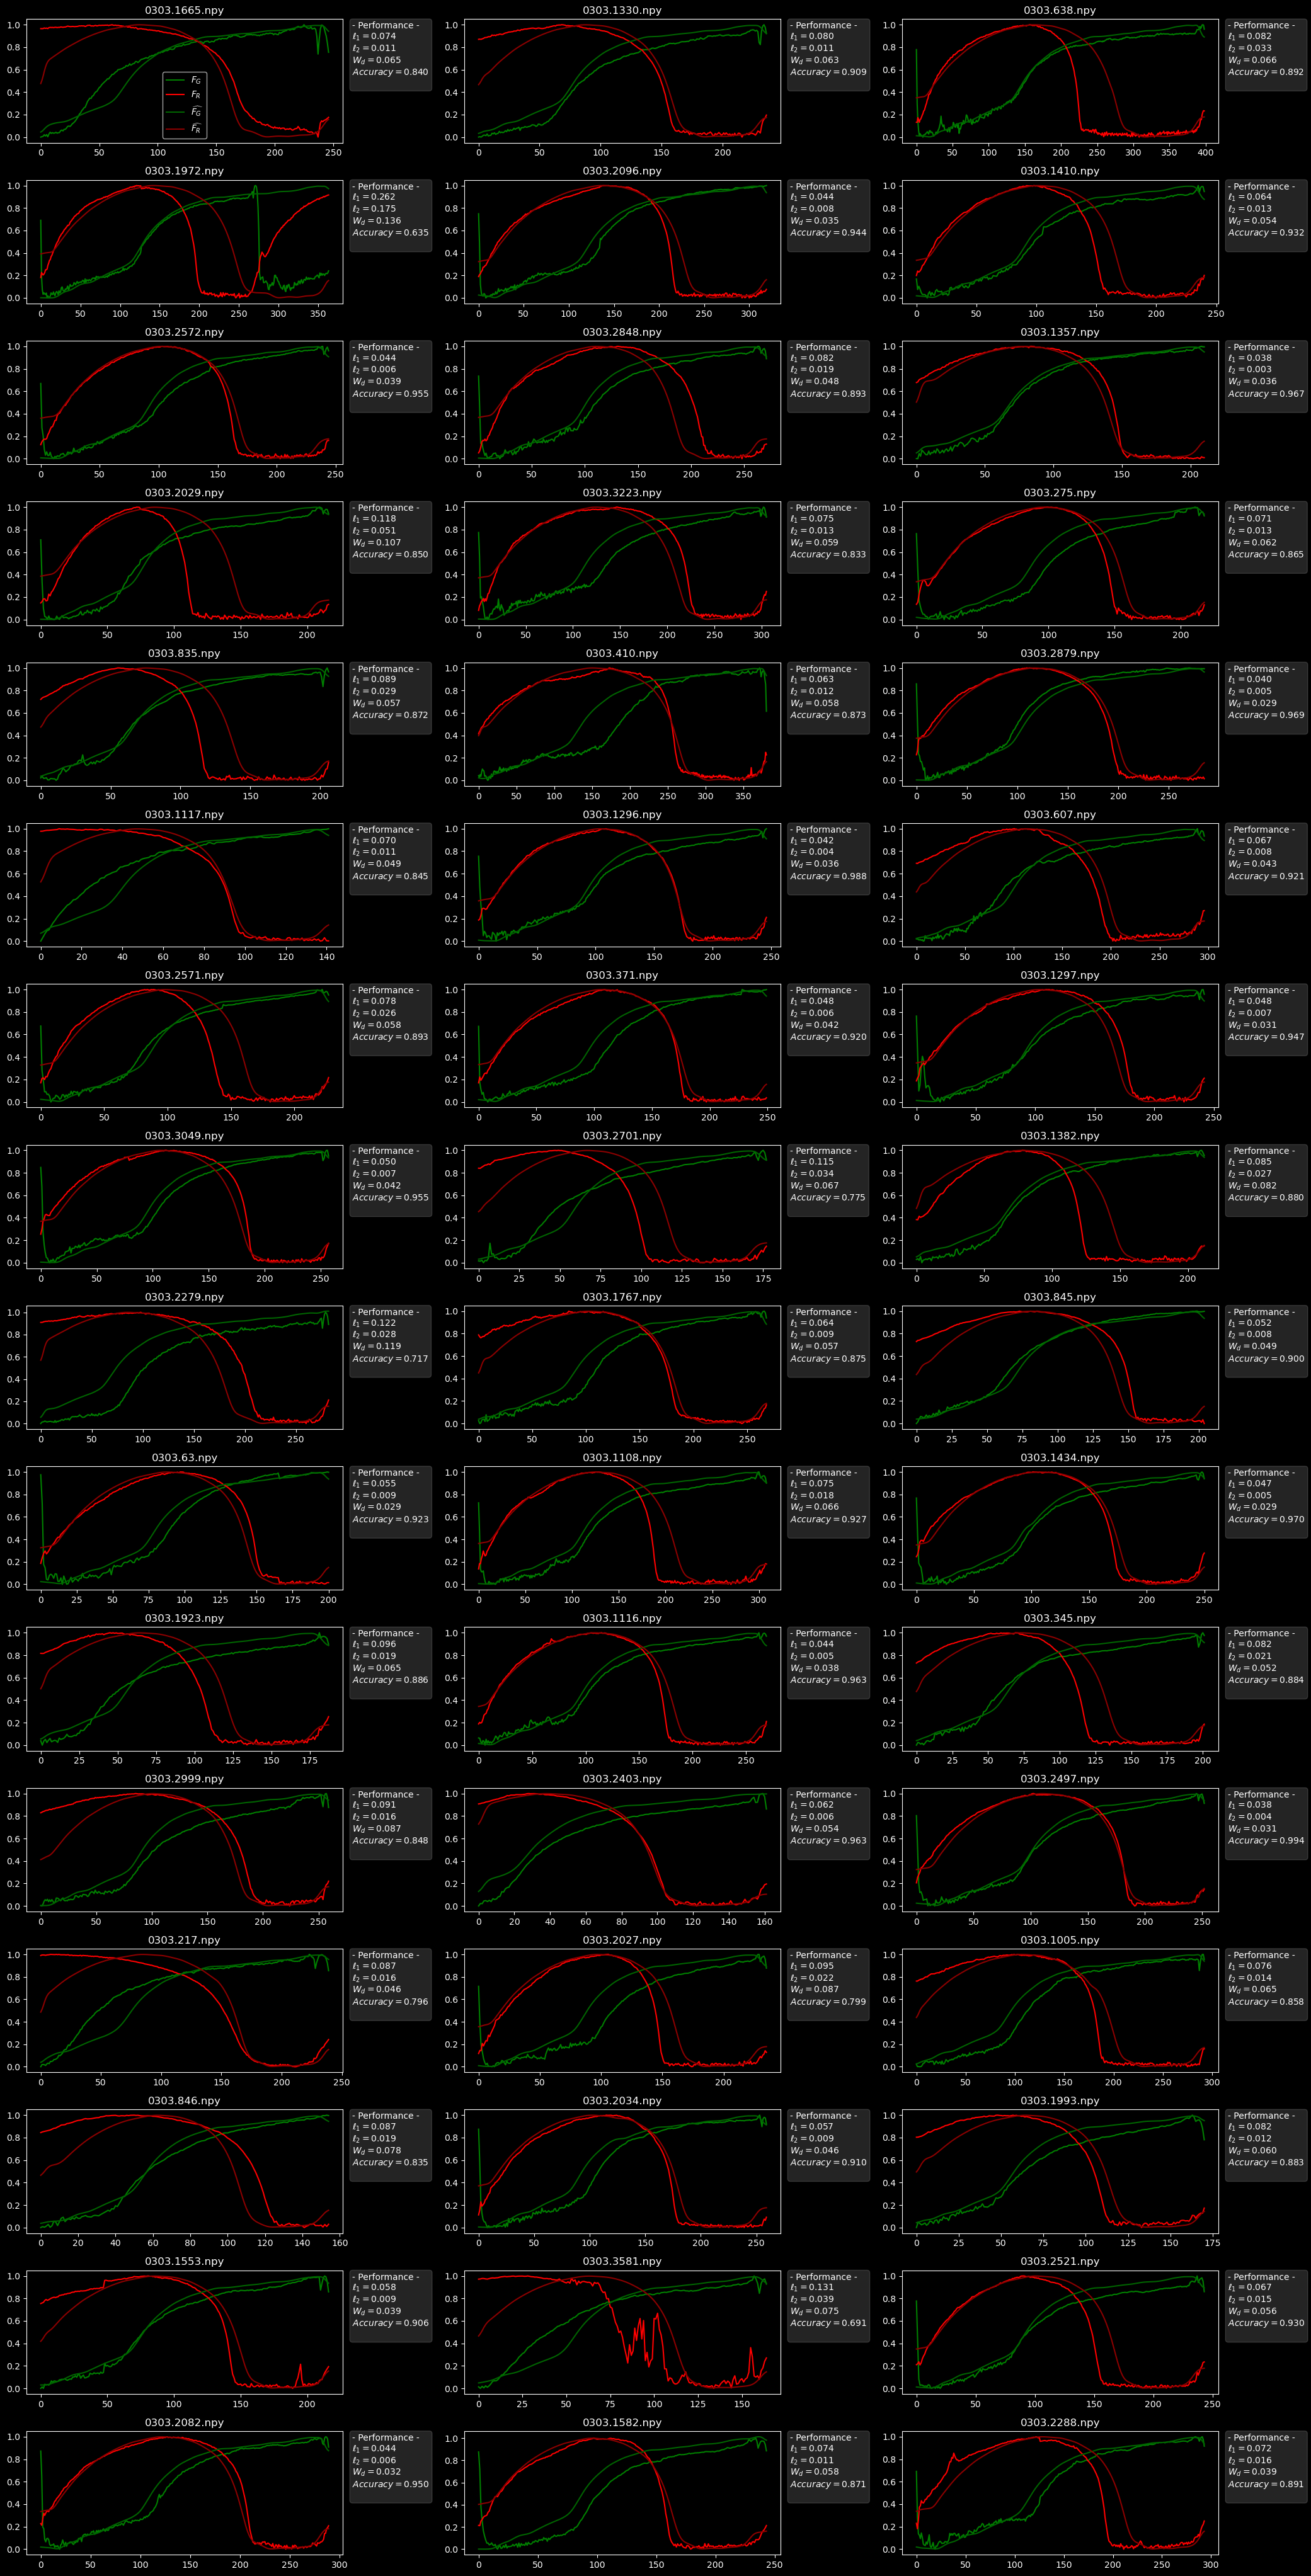

In [13]:
print(eval.summary())
eval.visualize_predicted_tracks(50)

In [14]:
eval.prediction_df.columns


Index(['CELL_ID', 'y', 'y_hat', '\ell_1', '\ell_2', 'W_d', 'Accuracy'], dtype='object')

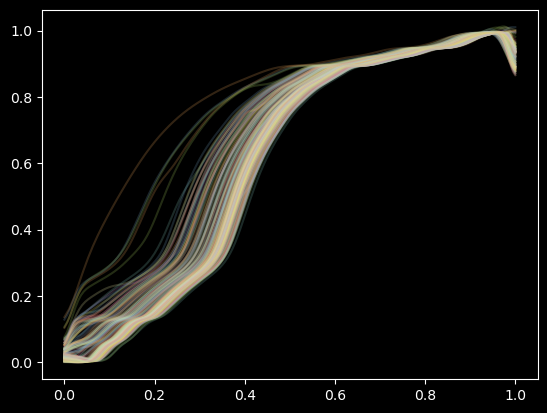

In [15]:
for i in range(200):
    track = eval.prediction_df.y_hat[i]
    tau = np.linspace(0, 1, track.shape[0])
    plt.plot(tau, track[:, 0], alpha=0.2)

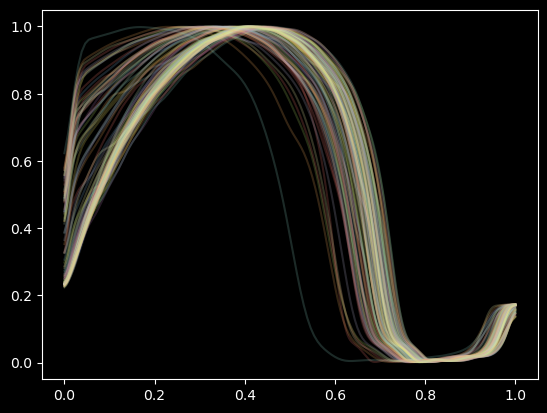

In [59]:
for i in range(100):
    track = eval.prediction_df.y_hat[i]
    tau = np.linspace(0, 1, track.shape[0])
    plt.plot(tau, track[:, 1], alpha=0.2)

# get phases

In [60]:
import os
from tqdm import tqdm

In [61]:
slice_p = 1.
random_len = True
slice_len = 10

# this is a copied and adapted function that gets random slices from the sequnces
# 

def random_slice(imgs, labels, random_len=True, slice_len=10):

    if random_len:
        slice_len = np.random.randint(slice_len, labels.shape[0] - 1)
    x = np.random.randint(0, labels.shape[0] - slice_len)
    return (
        imgs[x : x + slice_len],
        labels[x : x + slice_len],
    )  # minimum 2h of images

In [63]:
img_directory = PATH + "track_datasets/control_mm/test/images/"
label_directory = PATH + "track_datasets/control_mm/test/labels/"
cells = os.listdir(img_directory)[:]
# Initialize pandas cells so we can store tracks inside
# model.to(DEVICE)

ph = []
label = []
prediction = []
for idx, cell in enumerate(tqdm(cells)):
    # Get input with specific image channels and groundtruth FUCCI signal
    x = (
        torch.tensor(
            np.load(img_directory + cell, allow_pickle=True),
            dtype=torch.float32,
        )[:, [1], :, :]
        .to(DEVICE)
    )
    lab = np.load(label_directory + cell).reshape(2, -1).T


    if np.random.rand() < slice_p and lab.shape[0] > slice_len:
        x, lab = random_slice(x, lab)

    x = model.spatial_encoder(x.unsqueeze(0))
    x = model.temporal_encoder(model.fc_s2t(x))
    if model.temporal_encoder.__class__.__name__ == "LSTM":
        x = x[0]
    x = model.get_phi(x)
    pred = model.vanilla_fn(x)

    ph.append(x.detach().cpu().numpy().squeeze())
    label.append(lab)
    prediction.append(pred.detach().cpu().numpy().squeeze())

100%|██████████| 358/358 [00:05<00:00, 67.65it/s]


In [64]:
ph0 = [p[0] for p in ph]
ph_fn = [p[-1] for p in ph]

print(f"ph 0 mean {np.mean(ph0)} std {np.std(ph0)}")
print(f"ph fin mean {np.mean(ph_fn)} std {np.std(ph_fn)}")
print(f"ph 0 min {np.min(ph0)} max {np.max(ph0)}")
print(f"ph fin min {np.min(ph_fn)} max {np.max(ph_fn)}")


ph 0 mean 0.0013575630728155375 std 0.00016052967112045735
ph fin mean 0.997164249420166 std 0.000298199214739725
ph 0 min 0.001249220804311335 max 0.0023184195160865784
ph fin min 0.9953848123550415 max 0.9974367618560791


Text(0.5, 0, 'Normalized Time')

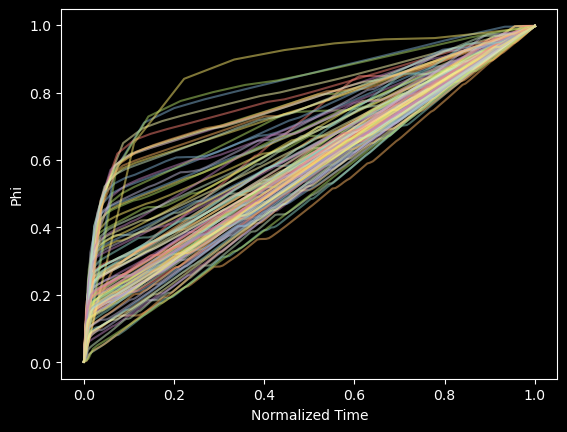

In [65]:
for i in range(100):
    plt.plot(np.linspace(0, 1, len(ph[i])), ph[i], alpha=0.5)

plt.ylabel("Phi")
plt.xlabel("Normalized Time")

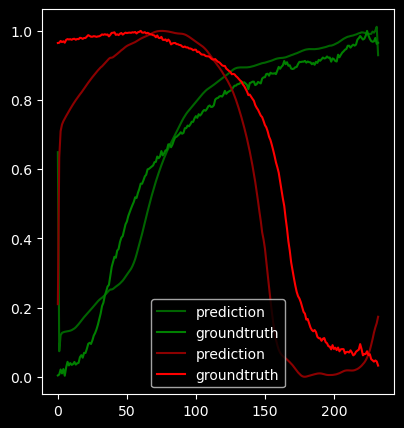

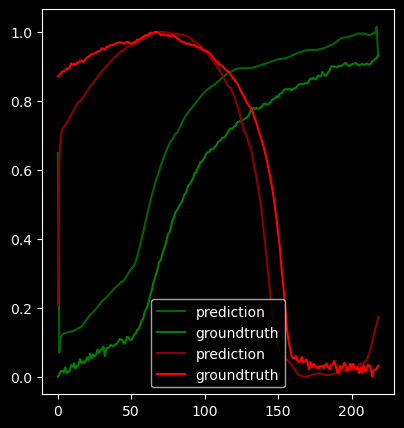

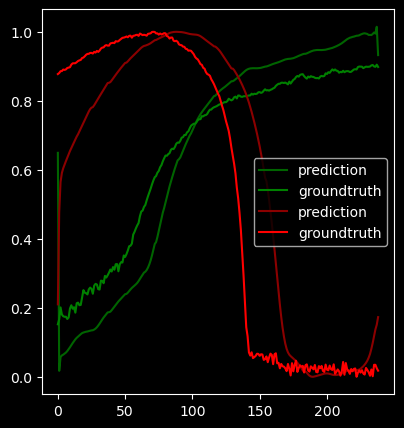

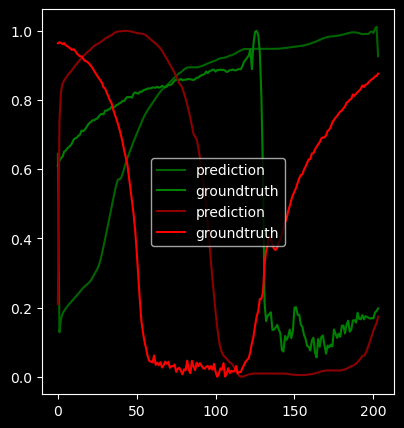

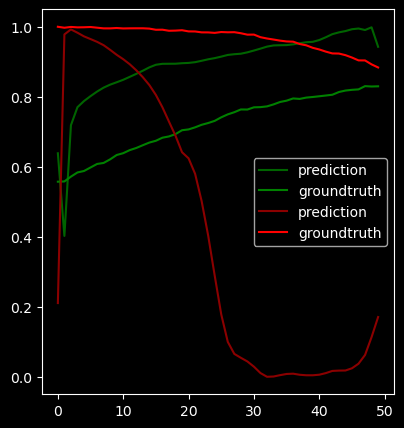

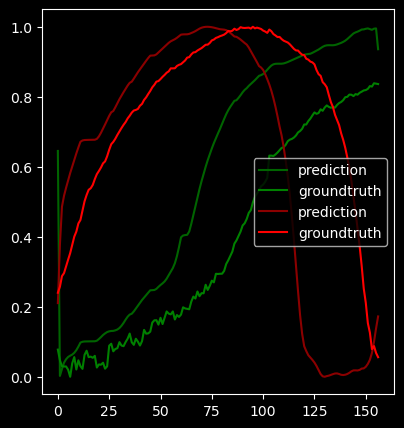

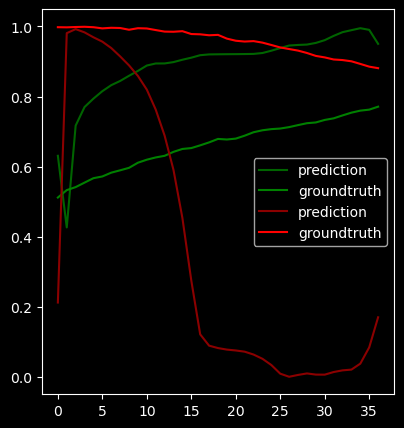

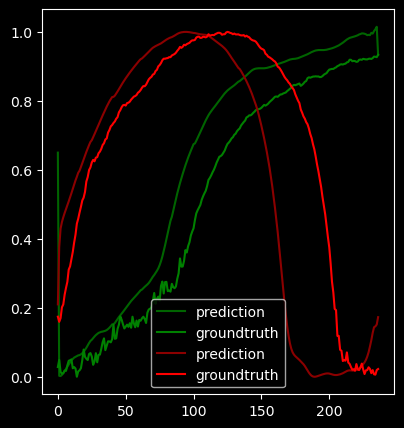

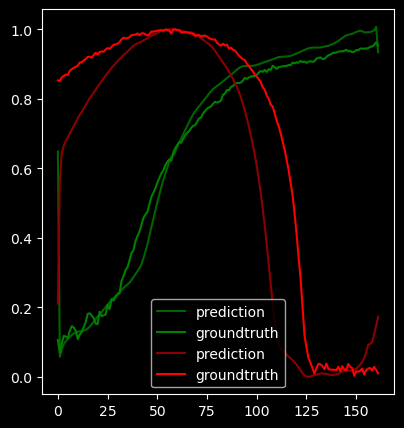

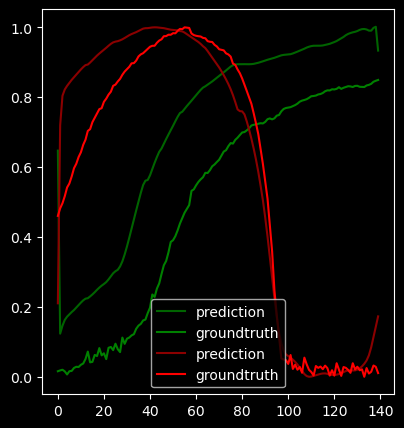

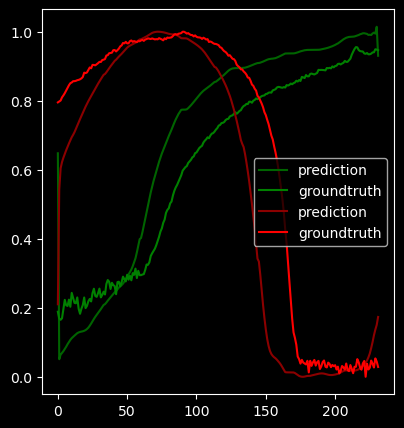

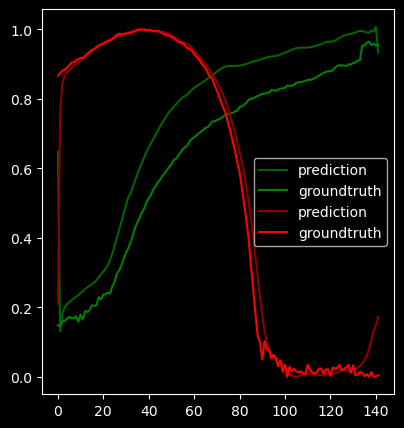

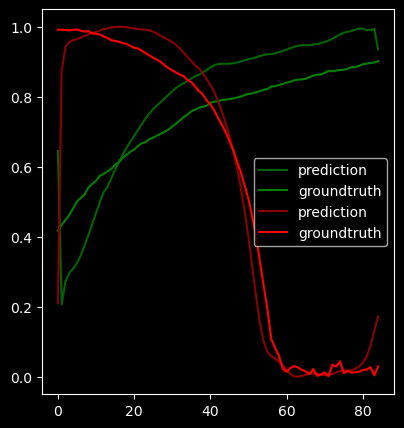

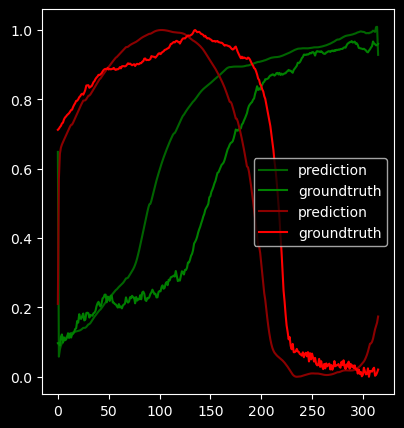

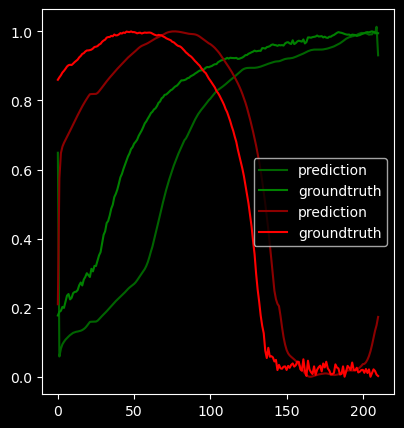

In [66]:
for i in range(15):
    tau = np.linspace(0, 1, len(label[i]))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)

    plt.plot(prediction[i][:,0], "darkgreen", label="prediction")
    plt.plot(label[i][:,0], "green",  label="groundtruth")
    plt.plot(prediction[i][:,1], "darkred", label="prediction")
    plt.plot(label[i][:,1], "red",  label="groundtruth")

    plt.legend()

    # plt.subplot(1, 2, 2)

    # plt.plot(ph[i], prediction[i][:,0], "darkgreen", label="prediction")
    # plt.plot(tau, label[i][:,0], "green",  label="groundtruth")
    # plt.plot(ph[i], prediction[i][:,1], "darkred", label="prediction")
    # plt.plot(tau, label[i][:,1], "red",  label="groundtruth")


    # plt.legend()
    # plt.show()